In [3]:
#import pyg_lib
from torch_geometric.loader import NeighborLoader
import torch_sparse
print("torch-sparse version:", torch_sparse.__version__)

torch-sparse version: 0.6.18+pt22cpu


In [2]:
from torch_geometric.datasets import Planetoid
 
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]
 
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
 
# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [4]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx
 
# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)
 
# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[413, 500], edge_index=[2, 465], y=[413], train_mask=[413], val_mask=[413], test_mask=[413], n_id=[413], e_id=[465], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[262, 500], edge_index=[2, 312], y=[262], train_mask=[262], val_mask=[262], test_mask=[262], n_id=[262], e_id=[312], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[275, 500], edge_index=[2, 317], y=[275], train_mask=[275], val_mask=[275], test_mask=[275], n_id=[275], e_id=[317], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[200, 500], edge_index=[2, 225], y=[200], train_mask=[200], val_mask=[200], test_mask=[200], n_id=[200], e_id=[225], input_id=[12], batch_size=12)


/home/ubuntu/anaconda3/envs/grp/lib/python3.9/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


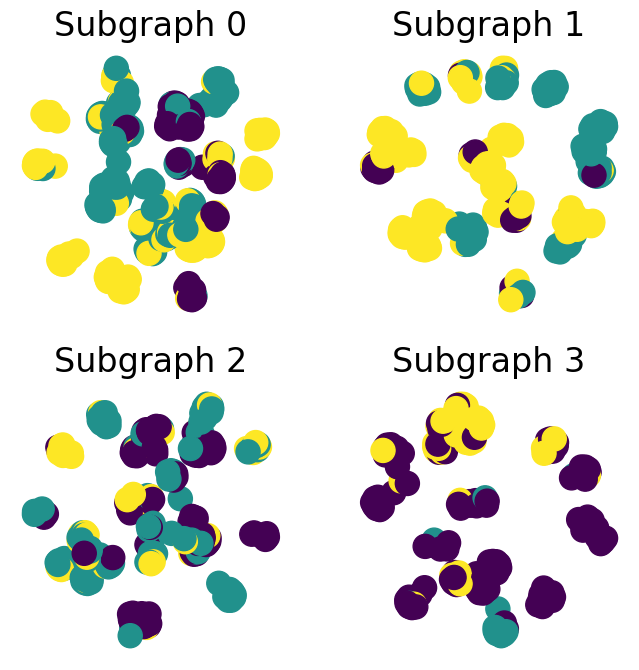

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Plot each subgraph
fig = plt.figure(figsize=(8,8))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_color=subdata.y,
                    )
plt.show()

In [8]:
# custom graphSAGE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing

class graphSAGE(MessagePassing):
    def __init__(self, dim_in, dim_out, aggregation='mean'):
        super().__init__()
       
        self.aggregation = aggregation
        self.linear = nn.Linear(2*dim_in, dim_out)  # [자기 노드 특성| 이웃 노드 특성]에 대한 선형 변환


    def forward(self, x, edge_index):    
        # message 전달
        h_self = x  # 자기 자신 노드 특성
        h_neigh = self.propagate(edge_index, x=x)  # 이웃 노드들의 평균 특성

        h_concat = torch.cat([h_self, h_neigh], dim=1)  # (N, 2 * in_channels)
        return self.linear(h_concat)  # Concat 후 Linear 변환
        #return out

In [9]:
def accuracy(pred_y, y):
    """정확도 계산"""
    return ((pred_y == y).sum() / len(y)).item()
    
import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
 
class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = graphSAGE(dim_in, dim_h) # default = mean aggregator
        self.sage2 = graphSAGE(dim_h, dim_out)
 
    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return F.log_softmax(h, dim=1)
 
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
 
        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0
 
            # Train on batches
            for batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()
 
                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
 
            # Print metrics every 10 epochs
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')
 
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [10]:
# GraphSAGE 생성
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)
 
# Train
graphsage.fit(data, 200)
 
# Test
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGE(
  (sage1): graphSAGE()
  (sage2): graphSAGE()
)
Epoch   0 | Train Loss: 0.380 | Train Acc:  26.46% | Val Loss: 1.13 | Val Acc: 37.76%
Epoch  20 | Train Loss: 0.002 | Train Acc:  98.61% | Val Loss: 0.87 | Val Acc: 57.36%
Epoch  40 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 68.75%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.09 | Val Acc: 65.00%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 71.67%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.54 | Val Acc: 72.86%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.98 | Val Acc: 68.33%
Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.67 | Val Acc: 71.62%
Epoch 160 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.66 | Val Acc: 64.38%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.06 | Val Acc: 60.42%
Epoch 200 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.76 | Val Acc: 71

sampling 과정까지도 random 함수로 구현

In [ ]:
# custom graphSAGE
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
class graphSAGE(nn.Module):
    def __init__(self, dim_in, dim_out, num_samples=5, aggregation='mean'):
        super().__init__()
       
        self.aggregation = aggregation
        self.linear = nn.Linear(2*dim_in, dim_out)  # 자기 노드 특성에 대한 선형 변환
        self.dim_out = dim_out
        self.num_neighbor = num_samples
    
    def get_neighbors(self, node, edge_index):
        """특정 노드의 이웃을 찾는 함수"""
        row, col = edge_index

        neighbors1 = col[row == node]
        neighbors2 = row[col == node]
        neighbors = list(set(neighbors1) | set(neighbors2))
        return neighbors

    def forward(self, x, edge_index): # batch
        """
        x: (N, in_features)  -> 노드 특성 행렬
        edge_index: (2, E)   -> 그래프의 간선 리스트
        """
        num_nodes = x.size(0)
        out = torch.zeros((num_nodes, self.dim_out))

        for i in range(num_nodes):
            # sampling
            neighbors = self.get_neighbors(i, edge_index)  # 올바른 인자 전달
            if len(neighbors) > self.num_neighbor:
                sampled_neighbors = random.sample(neighbors, self.num_neighbor)
            else:
                sampled_neighbors = neighbors
        
            sampled_neighbors = [t.item() for t in sampled_neighbors]
            sampled_neighbors_ = x[sampled_neighbors]  # 현재 노드 i의 이웃 중 num_neighbor 만큼 sampling
            
        # aggreate
            if self.aggregation == 'mean':
                neighbor_embedding = torch.mean(sampled_neighbors_, dim=0)  # 평균 집계
            elif self.aggregation == 'max':
                neighbor_embedding = torch.max(sampled_neighbors_, dim=0)[0]  # 최대값 집계
            else:
                raise ValueError(f"Unknown aggregation type: {self.aggregation}")
            
            concat = torch.cat((x[i], neighbor_embedding)) # 자기 특성과 이웃 특성을 결합
            #print(concat.size())
            out[i] = self.linear(concat)
        return out

In [16]:
def accuracy(pred_y, y):
    """정확도 계산"""
    return ((pred_y == y).sum() / len(y)).item()
    
import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
 
class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = graphSAGE(dim_in, dim_h) # default = mean aggregator
        self.sage2 = graphSAGE(dim_h, dim_out)
 
    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return F.log_softmax(h, dim=1)
 
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
 
        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0
 
            # Train on batches
            for batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()
 
                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
 
            # Print metrics every 10 epochs
            if epoch % 1 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')
 
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [17]:
# GraphSAGE 생성
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)
 
# Train
graphsage.fit(data, 10)
 
# Test
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGE(
  (sage1): graphSAGE(
    (linear): Linear(in_features=1000, out_features=64, bias=True)
  )
  (sage2): graphSAGE(
    (linear): Linear(in_features=128, out_features=3, bias=True)
  )
)
Epoch   0 | Train Loss: 0.285 | Train Acc:  16.54% | Val Loss: 1.11 | Val Acc: 27.11%
Epoch   1 | Train Loss: 0.268 | Train Acc:  80.82% | Val Loss: 1.06 | Val Acc: 56.73%
Epoch   2 | Train Loss: 0.250 | Train Acc:  93.06% | Val Loss: 0.99 | Val Acc: 78.83%
Epoch   3 | Train Loss: 0.210 | Train Acc:  90.47% | Val Loss: 0.89 | Val Acc: 70.21%
Epoch   4 | Train Loss: 0.155 | Train Acc:  95.04% | Val Loss: 0.78 | Val Acc: 77.50%
Epoch   5 | Train Loss: 0.116 | Train Acc:  93.50% | Val Loss: 0.66 | Val Acc: 84.24%
Epoch   6 | Train Loss: 0.089 | Train Acc:  96.61% | Val Loss: 0.55 | Val Acc: 84.33%
Epoch   7 | Train Loss: 0.064 | Train Acc:  93.65% | Val Loss: 0.51 | Val Acc: 86.46%
Epoch   8 | Train Loss: 0.062 | Train Acc:  93.49% | Val Loss: 0.38 | Val Acc: 90.83%
Epoch   9 | Train Loss: 0.033